## Problem Scenario:
In this project we have a dataset containing stock prices of Google from January-2012 to December-2016. We are required to use these stock prices for training the neural network and predict the stock prices for the month of January-2017. This is a Regression problem.

To achieve this goal, we will train a **Recurrent Neural Network (LSTM)**. We will use one of the deep learning libraries, **Keras**, to build the neural network.


## Importing the Libraries

In [1]:
#Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#This is a magic command. It will display the plotting image directly below the code cell
%matplotlib inline

## Importing the Dataset

In [8]:
import os
import pandas as pd

# Constructing the correct file path using os.path.join
dataset_train_path = os.path.join(os.getcwd(), "Dataset", "/content/Google_Stock_Price_Train.csv")

# Reading the CSV file into a pandas DataFrame
dataset_train = pd.read_csv(dataset_train_path)

# Displaying the first few rows of the DataFrame
dataset_train.head()


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


The dataset contains various information like displayed above. But in this project we will only use the "Open" stock prices for training our model. Therefore for the purpose of convenience we will create another variable that stores only the required ("Open" stock price) information.

In [9]:
training_set = dataset_train.iloc[:,1:2].values

print(training_set)
print("********************")
print(training_set.shape)

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]
********************
(1258, 1)


Now we can see that there is only one column with the Open stock prices. There are a total of 1258 stock prices.

In [10]:
#----------------------------------------------#
# Additional Information (Things to Remember!) #
#----------------------------------------------#

print(type(dataset_train))
print(type(dataset_train.iloc[:,1:2]))
print(type(dataset_train.iloc[:,1:2].values))

# iloc[rangeofRows, rangeofColumns]
# Indexing starts from zero.
# ":" indicates entire range.
# "1:2" indicates column one only. Because, the upper bound will be excluded.
# mathematical operation are performed on the arrays. So, it is crusial to convert the data to arrays.


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


## Feature scaling

The performance of the neural network will be better if the entire training input is in the same range. As we can see from above the stock prices are not in the same range. So, we need to scale the training data such that they are in the same range. This process is called Feature Scaling. The two popular methods for feature scaling are:

* **Standardization**

$ x' = \frac{x - \bar{x}}{\sigma} $

where $ x $ is the original feature vector, $ \bar{x} $ is the mean of that feature vector, and $ \sigma $ is its standard deviation.

* **Normalization** (Min-Max normalization)

$ x' = \frac{x - \text{min}(x)}{\text{max}(x)-\text{min}(x)} $

where $ x $ is an original value, $ x' $ is the normalized value.

It is recommended to use Normalization in the case of RNN networks. Therefore we use Min-Max normalization here. You may also experiment with different feature scaling methods.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)

scaled_training_set

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

The fit method only calculates the min and max values. It does not apply the formula on the training set. The fit_transform method applies the minmax formula on the training set. After applying the minmax formula, the transformed values will be in the range 0 and 1 i.e, the training data (features) will be in the range 0 and 1 (as shown above).

## Create new Data Structure

We will create a new data structure with 60 timesteps and 1 output. This means that the neural network will take in 60 inputs and produce one output. In our project, 60 stock prices i.e, stock prices corresponding to 3 previous months will be used to make the prediction. For example, the stock prices of Jan-12, Feb-12 and Mar-12 will be used to predict the stock price of the first day of Apr-12. In our training set there are 1258 stock prices:

    Stock Prices(Input)   Stock Price(Output)
    (X_train)               (y_train)
    -----------------------------------------
    1 to 60                  61
    2 to 61                  62
    3 to 62                  63
    ......                   ...
    1197 to 1257             1258

In the next section we will create X_train and y_train data structures.

In [12]:
X_train = []
y_train = []
for i in range(60,1258):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [13]:
print(X_train.shape)
print(y_train.shape)

(1198, 60)
(1198,)


## Reshaping

The input shape of the LSTM is 3D tensor with shape (batch_size, timesteps, input_dim). Batch_size represents the number of iterations required to traverse through the entire training data. Timesteps represent the number of inputs required for each prediction. In our scenario it is 60.

In [14]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(1198, 60, 1)

## Building the Neural Network

In [15]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [16]:
#--------------------------------------------#
#  Initialization and Adding layers to RNN   #
#--------------------------------------------#
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1], 1)))   # the first LSTM layer
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences= True))  # the second LSTM layer
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences= True))  # the third LSTM layer
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))  # the fourth LSTM layer
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))   # the dense layer

If no activation function is specified in the dense layer then the linear activation is performed by default wherein, the dense layer takes a weighted sum of its inputs which corresponds to the predicted output.

In [17]:
#-----------------------------------------------------#
#  Compiling and Fitting the RNN to the Training set  #
#-----------------------------------------------------#

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

# the loss function "mean_squared_error"(MSE) is used because it is a Regression problem.
# epochs = no of iterations. After every 32 (batch_size) datasets, the MSE will be calculated and
# the tweaks will be Back Propagated i.e., the weights will be tweaked for every 32 training datasets.

Epoch 1/100
38/38 [==============================] - 12s 131ms/step - loss: 0.0381
Epoch 2/100
38/38 [==============================] - 4s 106ms/step - loss: 0.0064
Epoch 3/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0058
Epoch 4/100
38/38 [==============================] - 7s 178ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0052
Epoch 6/100
38/38 [==============================] - 4s 104ms/step - loss: 0.0059
Epoch 7/100
38/38 [==============================] - 5s 122ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 4s 97ms/step - loss: 0.0050
Epoch 9/100
38/38 [==============================] - 4s 94ms/step - loss: 0.0050
Epoch 10/100
38/38 [==============================] - 5s 130ms/step - loss: 0.0044
Epoch 11/100
38/38 [==============================] - 4s 97ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 4s 95ms/step - loss: 0.0043
Epoch 13/100
38/3

You can experiment with various optimizers: https://keras.io/optimizers/


## Making Predictions

In [19]:
# getting the Actual Stock Prices of Jan-2017
import os
import pandas as pd

# Constructing the correct file path using os.path.join
dataset_test_path = os.path.join(os.getcwd(), "content", "/content/Google_Stock_Price_Test.csv")

# Reading the CSV file into a pandas DataFrame
dataset_test = pd.read_csv(dataset_test_path)

# Getting the Actual Stock Prices of Jan-2017
actual_stock_price = dataset_test.iloc[:, 1:2].values

# getting the Predicted Stock Prices of Jan-2017
# Step1 - preparing the input for the model
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)    # axis 0 = vertical concatination
inputs = dataset_total[len(dataset_total)- len(dataset_test)-60:].values   # so that we can get the base index

inputs = inputs.reshape(-1,1)     # before Reshaping- (80,) after Reshaping- (80,1)
inputs = scaler.transform(inputs) # we don't need to fit because we want to use the previously calculated min & max values.

X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

# Step2 - prediction
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


1/1 [==============================] - 2s 2s/step


We "tranform" the inputs because we want to maintain the consistency w.r.t what we feed to the network. In the end we "reverse transform" the data for the convenience of plotting. As you can see in the next section, the actual and predicted stock prices are in the original scale and are not in the transformed state.

For a detailed explaination regarding reshaping please read this post: http://anie.me/numpy-reshape-transpose-theano-dimshuffle/

## Visualising the Results

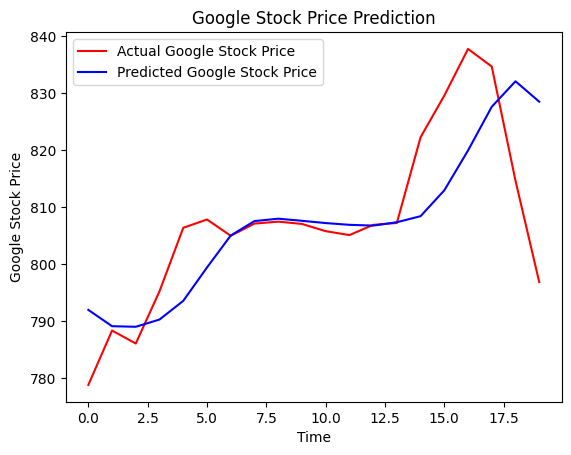

In [20]:
plt.plot(actual_stock_price, color = 'red', label = 'Actual Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()

We see that our model closely predicts the trend of the actual stock prices.

The model can be further improved and experimented by considering the following (but not limited to):
* training the model with more data. Eg: Here we have used 5 years of stock prices but you can train the model with 10 years of data.
* increasing the number of timesteps.
* adding more LSTM layers.
* increasing the units in the LSTM layer.
* adding some other indicators. Eg: If you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

P.S. These could also be computationally expensive.